In [1]:
from periodicLatticeSolver import PeriodicLatticeSolver
from minimizer import Minimizer
import numpy as np
from FloorPlanClass import FloorPlan
from plotter import Plotter
PLS = PeriodicLatticeSolver(200, .02)
PLS.add_Injector()

L1 = PLS.Variable('L1', varMin=.01, varMax=.5)
L2= PLS.Variable('L2', varMin=.01, varMax=.5)
L3 =PLS.Variable('L3', varMin=.01, varMax=.5)
L4= PLS.Variable('L4', varMin=.01, varMax=.5)

Bp1 = PLS.Variable('Bp1', varMin=.1, varMax=.45)
Bp2 = PLS.Variable('Bp2', varMin=.1, varMax=.45)
Bp3 = PLS.Variable('Bp3', varMin=.1, varMax=.45)
Bp4 = PLS.Variable('Bp4', varMin=.1, varMax=.45)

rp1 = PLS.Variable('rp1', varMin=.01, varMax=.03)
rp2 = PLS.Variable('rp2', varMin=.01, varMax=.03)
rp3 = PLS.Variable('rp3', varMin=.01, varMax=.03)
rp4 = PLS.Variable('rp4', varMin=.01, varMax=.03)

r0=1#PLS.Variable('r0',varMin=1,varMax=1.25)
TL1=PLS.Variable('TL1',varMin=.5,varMax=1.5)
TL2=PLS.Variable('TL2',varMin=.5,varMax=1.5)


PLS.set_Track_Length(TL1=TL1,TL2=TL2)
PLS.begin_Lattice()

PLS.add_Bend(np.pi, r0, .45)
#PLS.add_Drift(L=.03)
PLS.add_Lens(L4, Bp4, rp4)
PLS.add_Drift()
PLS.add_Combiner()
PLS.add_Drift()
PLS.add_Lens(L1, Bp1,rp1)
#PLS.add_Drift(L=.03)
PLS.add_Bend(np.pi, r0, .45)
#PLS.add_Drift(L=.03)
PLS.add_Lens(L2, Bp2, rp2)
PLS.add_Drift()
PLS.add_Lens(L3, Bp3, rp3)
#PLS.add_Drift(L=.03)
PLS.end_Lattice()

330 180
Lattice model completed


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


minCost for each thread:  [4.00000523 4.00012404 1.83311012 1.91709828 1.84258462 1.79824053
 1.85197377 1.9        1.86000546 1.9        1.83534805 1.89340584]


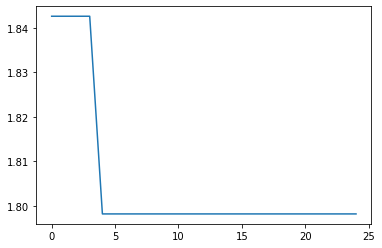

[ 0.14960195  0.5         0.33349775  0.2312562   0.222941    0.27985933
  0.4088873   0.34489487  0.01130368  0.0276237   0.02560144  0.01785734
  0.5         1.15663992  0.09918435  0.06715691 -0.01703047] 1.7982405315870933
percent particles surviving (x,y): 9.4, 9.4
[ 0.14960195  0.5         0.33349775  0.2312562   0.222941    0.27985933
  0.4088873   0.34489487  0.01130368  0.0276237   0.02560144  0.01785734
  0.5         1.15663992  0.09918435  0.06715691 -0.01703047] 1.7982405315870933
done
Total time 0 minutes and 23 seconds


In [2]:
minimizer=Minimizer(PLS)
minimizer.find_Global_Min(popPerDim=20,iterations=50)

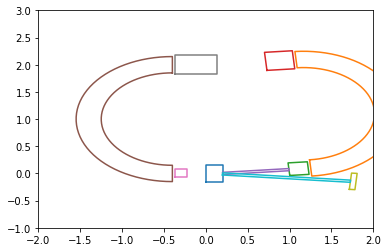

4.0

In [3]:
floorPlan=FloorPlan(PLS)
floorPlan.show_Floor_Plan(sol=minimizer.sol)
floorPlan.calculate_Cost()

[0.1496 0.5    0.3335 0.2313 0.2229 0.2799 0.4089 0.3449 0.0113 0.0276
 0.0256 0.0179 0.5    1.1566]


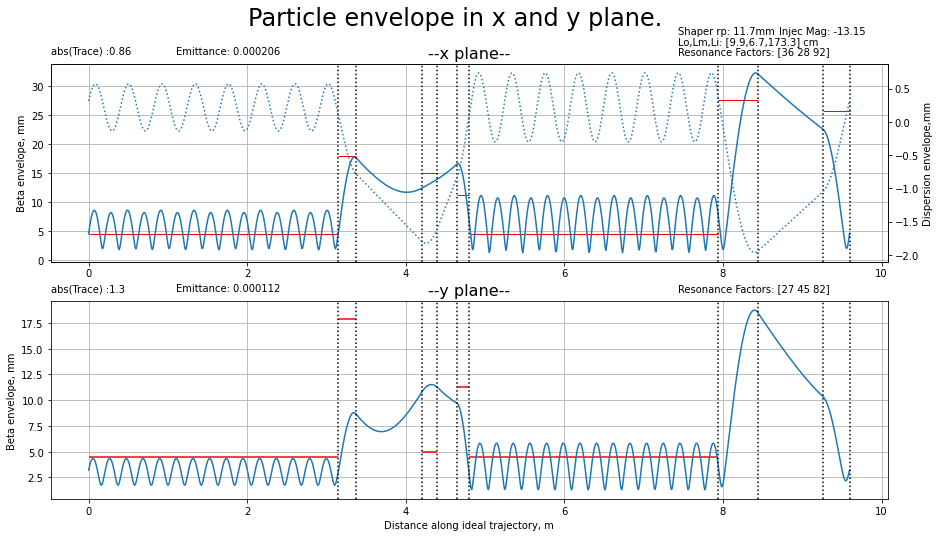

In [4]:
plotter=Plotter(PLS)
plotter.plot(sol=minimizer.sol)

In [5]:
floorPlan=FloorPlan(PLS)
args=[.5,.5,.5,.5,1,.2,.2,0]
floorPlan.build(args)
floorPlan.calculate_Cost()
floorPlan.show_Floor_Plan(args=args)

TypeError: _lambdifygenerated() missing 9 required positional arguments: 'rp1', 'rp2', 'rp3', 'rp4', 'TL1', 'TL2', 'L0', 'Lm', and 's_offset'

[0.1496 0.5    0.3335 0.2313 0.2229 0.2799 0.4089 0.3449 0.0113 0.0276
 0.0256 0.0179 0.5    1.1566]


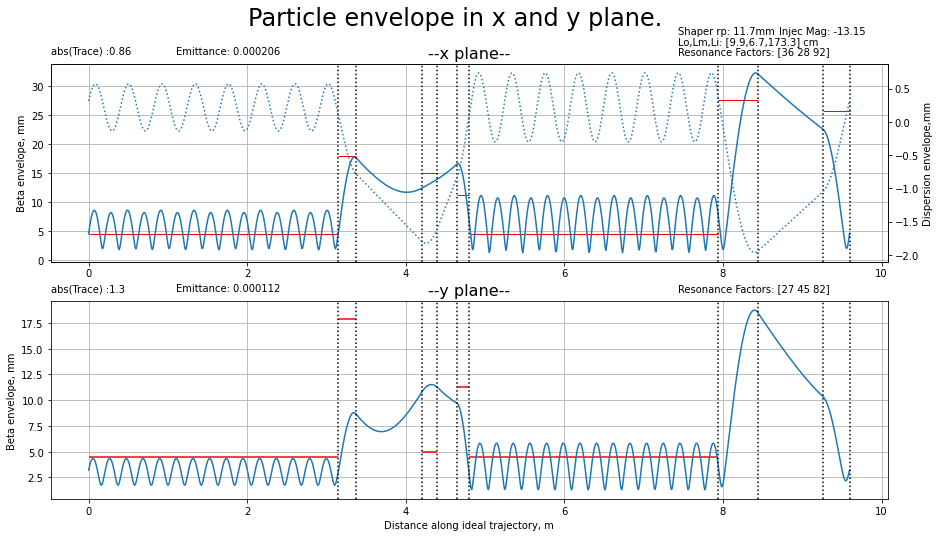

In [6]:
plotter=Plotter(PLS)
plotter.plot(sol=minimizer.sol)

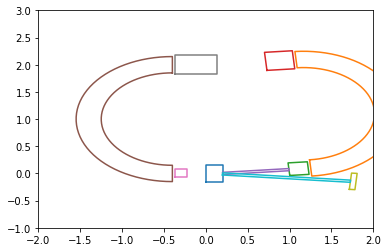

4.0

In [7]:
floorPlan=FloorPlan(PLS)
floorPlan.show_Floor_Plan(sol=minimizer.sol)
floorPlan.calculate_Cost()